In [21]:
""" Autoencoder denoising:
    2 layer auto-encoder 
    References:
        Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
        learning applied to document recognition." Proceedings of the IEEE,
        86(11):2278-2324, November 1998.
    Links:
        [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
"""
# %set_env LD_LIBRARY_PATH=/usr/local/cuda/lib64:/groups/mousebrainmicro/home/base/Apps/pycharm-community-2017.2/bin:/usr/lib:/usr/local/cuda/lib64:/usr/local/matlab-2017a/bin/glnxa64:/usr/local/matlab-2017a/runtime/glnxa64:/usr/local/matlab-2017a/sys/os/glnxa64:/usr/local/matlab-2017a/sys/java/jre/glnxa64/jre/lib/amd64/native_threads:/usr/local/matlab-2017a/sys/java/jre/glnxa64/jre/lib/amd64/server:/usr/local/matlab-2017a/sys/java/jre/glnxa64/jre/lib/amd64:/groups/mousebrainmicro/home/base/gurobi800/linux64/lib
# %env LD_LIBRARY_PATH

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True) 


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [23]:
# decoder/encoder scheme
def encoder(x):
    # sigmoid(W'*X+b) => X(Nxd) * W(dxL1) + b(L1x1)
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(x,weights['encoder_h1']),biases['encoder_h1']))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1,weights['encoder_h2']),biases['encoder_h2']))
    return layer2

def decoder(x):
    # sigmoid(W'*X+b) => X(Nxd) * W(dxL1) + b(L1x1)
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(x,weights['decoder_h1']),biases['decoder_h1']))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1,weights['decoder_h2']),biases['decoder_h2']))
    return layer2


In [24]:
# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

In [19]:
# define variables
X = tf.placeholder("float",[None,num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input,num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1,num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2,num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1,num_input])),
}
biases = {
    'encoder_h1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_input])),
}

In [30]:
encoder_ = encoder(X)
decoder_ = decoder(encoder_)
# prediction
y_pred = decoder_
y_true = X # denoising/reconstruction

In [42]:
# loss functions
loss = tf.reduce_mean(tf.pow(y_pred-y_true,2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

In [47]:
init = tf.global_variables_initializer()


In [62]:
num_steps

30000

In [63]:
# Start Training
# Start a new TF session
# with tf.Session() as sess:
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, 60000+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 0.449445
Step 1000: Minibatch Loss: 0.155854
Step 2000: Minibatch Loss: 0.125688
Step 3000: Minibatch Loss: 0.120219
Step 4000: Minibatch Loss: 0.108177
Step 5000: Minibatch Loss: 0.107439
Step 6000: Minibatch Loss: 0.103112
Step 7000: Minibatch Loss: 0.101939
Step 8000: Minibatch Loss: 0.099804
Step 9000: Minibatch Loss: 0.094813
Step 10000: Minibatch Loss: 0.092460
Step 11000: Minibatch Loss: 0.091476
Step 12000: Minibatch Loss: 0.091089
Step 13000: Minibatch Loss: 0.085756
Step 14000: Minibatch Loss: 0.082946
Step 15000: Minibatch Loss: 0.081084
Step 16000: Minibatch Loss: 0.080361
Step 17000: Minibatch Loss: 0.079076
Step 18000: Minibatch Loss: 0.077018
Step 19000: Minibatch Loss: 0.075447
Step 20000: Minibatch Loss: 0.071030
Step 21000: Minibatch Loss: 0.067842
Step 22000: Minibatch Loss: 0.067552
Step 23000: Minibatch Loss: 0.067245
Step 24000: Minibatch Loss: 0.064142
Step 25000: Minibatch Loss: 0.065594
Step 26000: Minibatch Loss: 0.064194
Step 27000: Mi

In [57]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i in range(n):
    # MNIST test set
    batch_x, _ = mnist.test.next_batch(n)
    # Encode and decode the digit image
    g = sess.run(decoder_, feed_dict={X: batch_x})

    # Display original images
    for j in range(n):
        # Draw the original digits
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
            batch_x[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(n):
        # Draw the reconstructed digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
            g[j].reshape([28, 28])            

Original Images


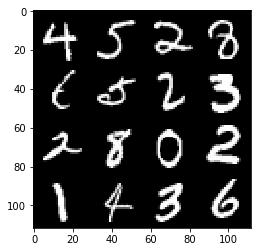

Reconstructed Images


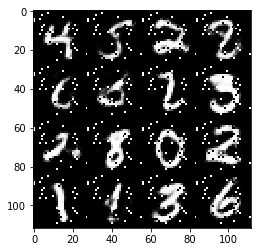

In [59]:
    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

In [50]:
12

12

True